# trip frequency for each day of the week of a month


reference:stephanlin

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from scipy import cluster
from random import randint
import time
data=pd.read_csv("green_tripdata_2015-07.csv")

In [2]:
data.head()

,VendorID,lpep_pickup_datetime,Lpep_dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type,PickupCell,DropoffCell,Unnamed: 23
0,2,2015-07-01 00:01:10,2015-07-01 00:19:04,N,1,-73.940628,40.715027,-73.912315,40.760380,1,...,0.00,0.0,NaN,0.3,16.80,2,1.0,37:68,36:57,NaN
1,2,2015-07-01 00:05:35,2015-07-01 00:17:42,N,1,-73.951134,40.804947,-73.867218,40.818989,1,...,0.00,0.0,NaN,0.3,19.30,1,1.0,25:54,36:42,NaN
2,2,2015-07-01 00:00:27,2015-07-01 00:03:40,N,1,-73.873878,40.742409,-73.889275,40.739227,1,...,0.03,0.0,NaN,0.3,6.33,1,1.0,44:55,42:58,NaN
3,2,2015-07-01 00:00:29,2015-07-01 00:05:30,N,1,-73.903488,40.745758,-73.905785,40.737576,2,...,0.00,0.0,NaN,0.3,6.80,2,1.0,39:58,40:60,NaN
4,2,2015-07-01 00:00:22,2015-07-01 00:10:43,N,1,-73.845810,40.720570,-73.810677,40.701687,1,...,0.00,0.0,NaN,0.3,11.80,2,1.0,51:55,59:54,NaN


In [48]:

timestamp = pd.to_datetime(pd.Series(data['lpep_pickup_datetime']))
data['weekday'] = timestamp.dt.weekday_name

#drop unnecessary column
df=data
df = df.drop(['Store_and_fwd_flag','VendorID','Ehail_fee','Unnamed: 23'], axis=1)
df=df.dropna()
df.head()


,lpep_pickup_datetime,Lpep_dropoff_datetime,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,...,Tip_amount,Tolls_amount,improvement_surcharge,Total_amount,Payment_type,Trip_type,PickupCell,DropoffCell,weekday,Cluster
0,2015-07-01 00:01:10,2015-07-01 00:19:04,1,-73.940628,40.715027,-73.912315,40.760380,1,4.33,15.5,...,0.00,0.0,0.3,16.80,2,1.0,37:68,36:57,Wednesday,7
1,2015-07-01 00:05:35,2015-07-01 00:17:42,1,-73.951134,40.804947,-73.867218,40.818989,1,6.11,18.0,...,0.00,0.0,0.3,19.30,1,1.0,25:54,36:42,Wednesday,83
2,2015-07-01 00:00:27,2015-07-01 00:03:40,1,-73.873878,40.742409,-73.889275,40.739227,1,0.96,5.0,...,0.03,0.0,0.3,6.33,1,1.0,44:55,42:58,Wednesday,87
3,2015-07-01 00:00:29,2015-07-01 00:05:30,1,-73.903488,40.745758,-73.905785,40.737576,2,1.04,5.5,...,0.00,0.0,0.3,6.80,2,1.0,39:58,40:60,Wednesday,49
4,2015-07-01 00:00:22,2015-07-01 00:10:43,1,-73.845810,40.720570,-73.810677,40.701687,1,2.48,10.5,...,0.00,0.0,0.3,11.80,2,1.0,51:55,59:54,Wednesday,0


In [47]:

#regression function for calculating score
def fit_model(X, y):
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X, y)
    return model

def score_model(model, X, y, Xv, yv):
    return tuple([model.score(X, y), model.score(Xv, yv)])

def fit_model_and_score(data, response, validation, val_response):
    model = fit_model(data, response)
    return score_model(model, data, response, validation, val_response)

In [49]:
def poly_regression(my_month,my_weekday,df):
    #get all the selected weekdays in selected month
    df_select=df[(df['weekday']==my_weekday) & 
                 (pd.to_datetime(df['lpep_pickup_datetime']) < pd.datetime(2015,my_month+1,1))&
                (pd.to_datetime(df['lpep_pickup_datetime']) > pd.datetime(2015,my_month,1))]
    
    df_select=df
    #use Kmean to group data by longitude and latitude
    my_cluster=100
    lon=df_select['Pickup_longitude'].values
    lat=df_select['Pickup_latitude'].values
    coodinate_array=np.array([[lon[i],lat[i]] for i in range(len(lon))])
    
    kmeans_n = KMeans(n_clusters=my_cluster,n_init=1,random_state=1000)
    kmeans_n.fit(coodinate_array)
    labels = kmeans_n.labels_
    
    # add new column call cluster
    df_select['Cluster']=labels
    
    #prepare for regression
    Cluster_size=df_select.groupby('Cluster').size()
    Cluster_size=np.array([[Cluster_size[i]] for i in range(len(Cluster_size))])
    Cluster_center=kmeans_n.cluster_centers_
    
    #get training data and testing data
    train_size=int(len(Cluster_size)*0.8)
    test_size=int(len(Cluster_size)*0.2)
    train_feature=Cluster_size[:train_size]
    train_response=Cluster_center[:train_size]
    test_feature=Cluster_size[test_size:]
    test_response=Cluster_center[test_size:]
    
    #coefficient of determination (R^2)
    print ("coefficient of determination (R^2):",fit_model_and_score(train_feature, train_response,
                           test_feature, test_response))
    
    #use mean squared error to evaluation model
    MSE_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])
    MSE_model.fit(train_feature, train_response)
    X_MSE=(test_feature)
    y_MSE = MSE_model.predict(X_MSE)
    print("MSE: ",mean_squared_error(test_response, y_MSE))
    
    #predict best location
    X=Cluster_size
    
    
    y=Cluster_center

    prediction_model=Pipeline([('poly', PolynomialFeatures(degree=3)),
                    ('linear', LinearRegression(fit_intercept=False))])
    prediction_model.fit(X, y)
    X_predict=([max(Cluster_size)])
    y_predict = prediction_model.predict(X_predict)
    print("best location for ",my_weekday, y_predict)
    
    #prepare for visualization
    for data in y_predict:
        visual_x=data[[0]]
        visual_y=data[[1]]
    
    for i in range(len(Cluster_size)):
        if (Cluster_size[i]==Cluster_size.max()):
            max_size_cluster=i
        
    actual_value=kmeans_n.cluster_centers_[max_size_cluster]
    actual_x=actual_value[0]
    actual_y=actual_value[1]
        
    #visualization for Kmean
    colors = []

    for i in range(my_cluster):
        colors.append('#%06X' % randint(0, 0xFFFFFF))

    
    plt.title("visualization for kmean")
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    for i in range(my_cluster):
        my_cluster_df=df_select[df_select['Cluster']==i]
        lon_x=my_cluster_df.Pickup_longitude.values
        lat_y=my_cluster_df.Pickup_latitude.values
        plt.scatter(lon_x,lat_y,alpha=0.2,s=100,c=colors[i])
    plt.show()
        
    #scatter plot all the data for selected weekday and prediction(best location in red)
    fig = plt.figure(figsize=(18,9))
    ax = fig.add_subplot(111)
    x_points=lon
    y_points=lat
    
    ax.scatter(lon,lat,alpha=0.2,c='b',s=100)
    ax.scatter(visual_x,visual_y ,c='r',s=100)
    ax.scatter(actual_x,actual_y ,c='y',s=100)
    ax.title.set_text("Best pick up location (red point=predicted point, yellow point=actual point)")
    

coefficient of determination (R^2): (0.06160620791878606, 0.10189091159778203)
MSE:  0.0043108618439538305
best location for  Wednesday [[-73.95150769  40.76805729]]


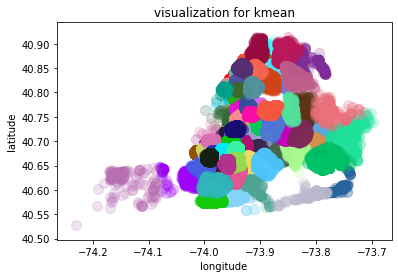

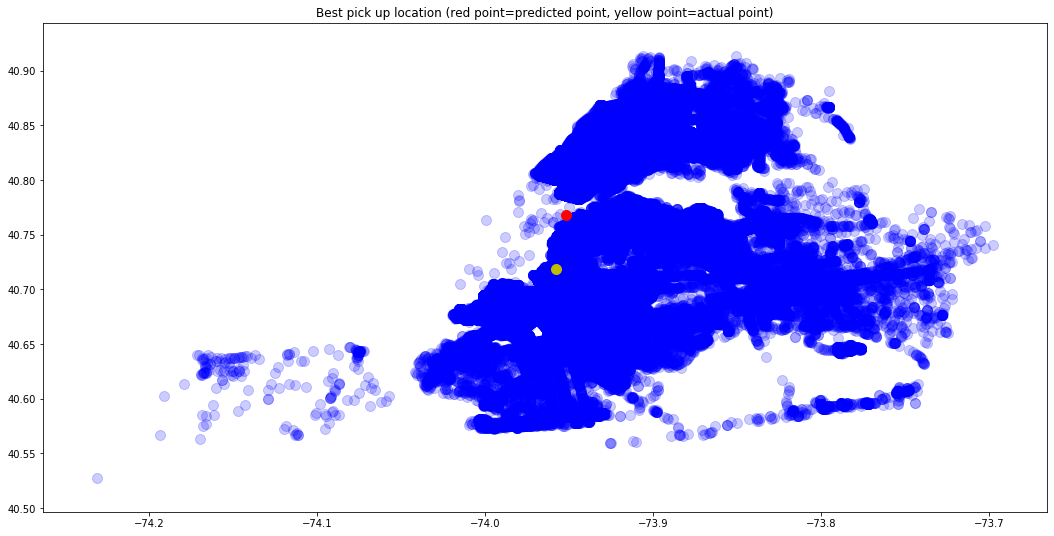

In [50]:
dayweek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
poly_regression(1,dayweek[2],df)